In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import time

In [2]:
fashion_mnist=keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [3]:
print("X_train shape:" + str(X_train.shape))
print("y_train shape:" + str(y_train.shape))
print("X_test shape:" + str(X_test.shape))
print("y_test shape:" + str(y_test.shape))

X_train shape:(60000, 28, 28)
y_train shape:(60000,)
X_test shape:(10000, 28, 28)
y_test shape:(10000,)


In [4]:
X_train = X_train/255.0
X_test = X_test/255.0

In [5]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
"Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

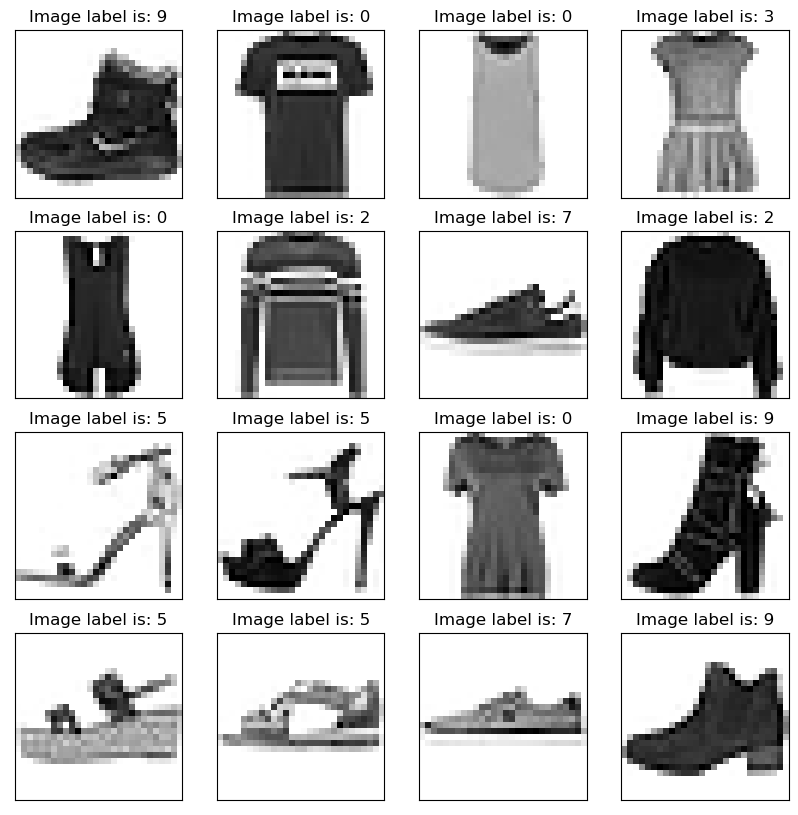

In [6]:
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.title("Image label is: {}".format(y_train[i]))
plt.show()

In [7]:
X_train = X_train.reshape(60000,-1)
X_test = X_test.reshape(10000,-1)

In [8]:
start_time = time.time()
log_reg = LogisticRegression(multi_class="ovr", solver="saga", max_iter = 1000, random_state=42)
log_reg.fit(X_train, y_train)
end_time = time.time()
print(log_reg.score(X_test, y_test))
print(f"Total time taken = {end_time-start_time}")

0.841
Total time taken = 2790.3460438251495


In [9]:
k=[100,200,300]
start_time = time.time()
for i in k:
    pipeline = Pipeline([("kmeans", KMeans(n_clusters=i, random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="saga", max_iter=5000, random_state=42))])
    pipeline.fit(X_train, y_train)
    print(f"No. of cluster = {i}, Accuracy = {pipeline.score(X_test, y_test)}")
end_time = time.time()
print(f"Total time taken = {end_time-start_time}")    

D:\Program Files\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


No. of cluster = 100, Accuracy = 0.8262
No. of cluster = 200, Accuracy = 0.8389


D:\Program Files\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Program Files\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


No. of cluster = 300, Accuracy = 0.8456
Total time taken = 13608.108580589294


D:\Program Files\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [10]:
k=[1000,2000,3000]
start_time=time.time()
for i in k:
    log_reg = LogisticRegression(multi_class="ovr", solver="saga", max_iter=5000, random_state=42)
    log_reg.fit(X_train[:i], y_train[:i])
    print(f"Labelled Instance = {i}, Accuracy = {log_reg.score(X_test, y_test)}")
end_time = time.time()
print(f"Total time taken = {end_time-start_time}")

Labelled Instance = 1000, Accuracy = 0.7886
Labelled Instance = 2000, Accuracy = 0.8052
Labelled Instance = 3000, Accuracy = 0.8087
Total time taken = 259.4390859603882


In [11]:
start_time=time.time()
kmeans = KMeans(n_clusters=3000, random_state=42)
X_items_dist = kmeans.fit_transform(X_train)
representative_item_idx = np.argmin(X_items_dist, axis=0)
X_representative_items = X_train[representative_item_idx]
end_time = time.time()
print(f"Total time taken = {end_time-start_time}")

Total time taken = 1874.8101634979248


In [12]:
y_train[representative_item_idx]

array([8, 3, 7, ..., 8, 8, 6], dtype=uint8)

In [13]:
y_representative_items = np.array(y_train[representative_item_idx])

In [14]:
start_time=time.time()
log_reg = LogisticRegression(multi_class="ovr", solver="saga", max_iter=1000, random_state=42)
log_reg.fit(X_representative_items, y_representative_items)
end_time = time.time()
print(log_reg.score(X_test, y_test))
print(f"Total time taken = {end_time-start_time}")

0.8075
Total time taken = 129.0275113582611


In [15]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(3000):
    y_train_propagated[kmeans.labels_==i] = y_representative_items[i]

In [16]:
start_time=time.time()
log_reg = LogisticRegression(multi_class="ovr", solver="saga", max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train_propagated)
end_time = time.time()
print(log_reg.score(X_test,y_test))
print(f"Total time taken = {end_time-start_time}")

0.8103
Total time taken = 2775.995676279068


In [17]:
percentile_closest = 25

X_cluster_dist = X_items_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(3000):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [18]:
start_time = time.time()
log_reg = LogisticRegression(multi_class="ovr", solver="saga", max_iter=1000, random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
end_time = time.time()
print(f"Percentile Closest = {percentile_closest}, Accuracy = {log_reg.score(X_test,y_test)}")
print(f"Total time taken = {end_time-start_time}")

Percentile Closest = 25, Accuracy = 0.8057
Total time taken = 653.0956494808197


In [19]:
percentile_closest = 50

X_cluster_dist = X_items_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(3000):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [20]:
start_time = time.time()
log_reg = LogisticRegression(multi_class="ovr", solver="saga", max_iter=1000, random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
end_time = time.time()
print(f"Percentile Closest = {percentile_closest}, Accuracy = {log_reg.score(X_test,y_test)}")
print(f"Total time taken = {end_time-start_time}")

Percentile Closest = 50, Accuracy = 0.8115
Total time taken = 1306.629417181015


In [21]:
percentile_closest = 75

X_cluster_dist = X_items_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(3000):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [22]:
start_time = time.time()
log_reg = LogisticRegression(multi_class="ovr", solver="saga", max_iter=1000, random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
end_time = time.time()
print(f"Percentile Closest = {percentile_closest}, Accuracy = {log_reg.score(X_test,y_test)}")
print(f"Total time taken = {end_time-start_time}")

Percentile Closest = 75, Accuracy = 0.8081
Total time taken = 1965.6906042099
